# Endowment Economy

## Calibration with non homothetic demand

In [14]:
using NLsolve, Plots, Parameters, Distributions, ProgressMeter, Statistics, StatsPlots

@with_kw struct Calibration
    #Households
    σ::Float64=0.5                      # elasticity of relative demand with respect to price sigma=0.5 completementary goods
    γ::Array{Float64}=[1/3, 1/3, 1/3]   # intensity in each good
    ϵ::Array{Float64}=[0.8, 1.0, 1.25]   # elasticity of relative demand with respect to income in luxury good sector
    ρ::Float64 =(σ-1)/σ                 
end

cal = Calibration()

Calibration
  σ: Float64 0.5
  γ: Array{Float64}((3,)) [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  ϵ: Array{Float64}((3,)) [0.8, 1.0, 1.25]
  ρ: Float64 -1.0


## How we solve for non homothetic utility. 
- Endowment translates into wealth since it can be sold on the market. 
- Utility maximization by solving for demand non linearities yield the non homothetic demand.

In [15]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(γ[i]^(1/σ)*(((p[i]/E)^(-σ)*γ[i])/u^((1-σ)*σ*ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(γ[i]*U^(ϵ[i]*(1-σ)^2) * (p[i]^(1-σ)) for i = 1:length(C))^(1/(1-σ))
    
    #Optimal Demand with income effect
    C1=γ[1]*U^(ϵ[1]*(1-σ)^2)  * (p[1]/E)^(-σ)
    C2=γ[2]*U^(ϵ[2]*(1-σ)^2)  * (p[2]/E)^(-σ)
    C3=γ[3]*U^(ϵ[3]*(1-σ)^2)  * (p[3]/E)^(-σ)

    #Expenditure share with income effect
    ω_p=γ[1]*U^(ϵ[1]*(1-σ)^2)  * (p[1]/E)^(1-σ)
    ω_n=γ[2]*U^(ϵ[2]*(1-σ)^2)  * (p[2]/E)^(1-σ)
    ω_l=γ[3]*U^(ϵ[3]*(1-σ)^2)  * (p[3]/E)^(1-σ)

    #Optimal update for demand
    ω=[ω_p, ω_n, ω_l]
    W=ω_p+ω_n+ω_l

    return [C1, C2, C3, U, ω  , E, ExpNH]#, U, E, ω]

end

NHUtility (generic function with 1 method)

In [16]:
C1=[]
C2=[]
C3=[]
U=[]
E=[]
@showprogress for i=LinRange(0.5,5,30)
    for j=LinRange(0.5,5,30)
        for k=LinRange(0.5,5,30)
            res=NHUtility([i,j,k], [2.0, 3.0, 5.0])
            C1=push!(C1, res[1])
            C2=push!(C2, res[2])
            C3=push!(C3, res[3])
            U=push!(U, res[4])
            E=push!(E, res[7])
        end
    end
    sleep(0.0001)
end

demand=[C1 C2 C3 U E]
demand=sortslices(demand,dims=1,by=x->(x[5]),rev=false)

X=demand[:,[1,2,3]]

Progress:   7%|██▊                                      |  ETA: 0:00:14

Progress:  10%|████▏                                    |  ETA: 0:00:11

Progress:  13%|█████▌                                   |  ETA: 0:00:09

Progress:  17%|██████▉                                  |  ETA: 0:00:08

Progress:  20%|████████▎                                |  ETA: 0:00:07

Progress:  23%|█████████▋                               |  ETA: 0:00:06

Progress:  27%|██████████▉                              |  ETA: 0:00:05

Progress:  30%|████████████▎                            |  ETA: 0:00:05

Progress:  33%|█████████████▋                           |  ETA: 0:00:05

Progress:  40%|████████████████▍                        |  ETA: 0:00:04

Progress:  47%|███████████████████▏                     |  ETA: 0:00:03

Progress:  50%|████████████████████▌                    |  ETA: 0:00:03

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:03

Progress:  60%|████████████████████████▋                |  ETA: 0:00:02

Progress:  63%|██████████████████████████               |  ETA: 0:00:02

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:01

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:01

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


27000×3 Matrix{Float64}:
 0.622845  0.530234  0.432722
 0.656653  0.562203  0.462086
 0.673461  0.578163  0.476821
 0.690208  0.594107  0.49159
 0.706895  0.610035  0.506393
 0.706895  0.610035  0.506393
 0.723524  0.625948  0.521228
 0.723524  0.625948  0.521228
 0.740097  0.641846  0.536095
 0.740097  0.641846  0.536095
 ⋮                   
 4.5485    4.78652   5.09145
 4.56099   4.80105   5.10876
 4.56099   4.80105   5.10876
 4.57348   4.81559   5.12608
 4.57348   4.81559   5.12608
 4.58596   4.83012   5.1434
 4.59844   4.84465   5.16073
 4.61091   4.85918   5.17806
 4.63583   4.88823   5.21273

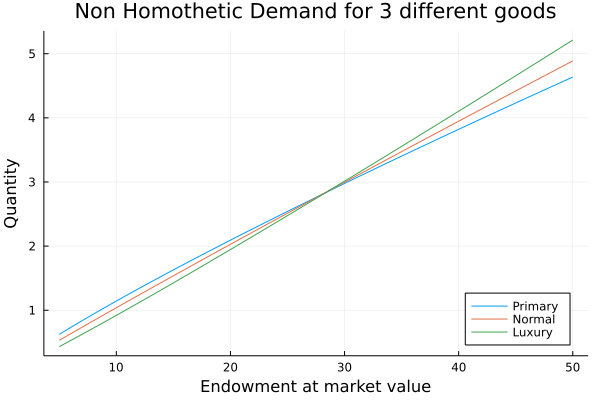

In [17]:
p1=plot(demand[:,5],X, 
title="Non Homothetic Demand for 3 different goods", 
xlabel="Endowment at market value",
ylabel="Quantity",
label=["Primary" "Normal" "Luxury"] ,
legend=:bottomright)

savefig(p1, "Figures/NHdemand.png") # save the most recent fig as filename_string (such as "output.png")
p1

## Environment

In this example, prices were first given at p=[4.0, 5.0, 10.0].

However, this price level does not clear the market, we have demand that takes over endowment level in our economy. Hence we update the price level such that non homothetic is exactly equal to the endowment level.

We set 3 sectors with 300 agents.

### Random endowments

- Lognormal for luxury products
- Normal distribution for Primary and Normal, higher quantity for primary quantity

In terms of aggregate quantity : $ Q_P>Q_N>Q_L$

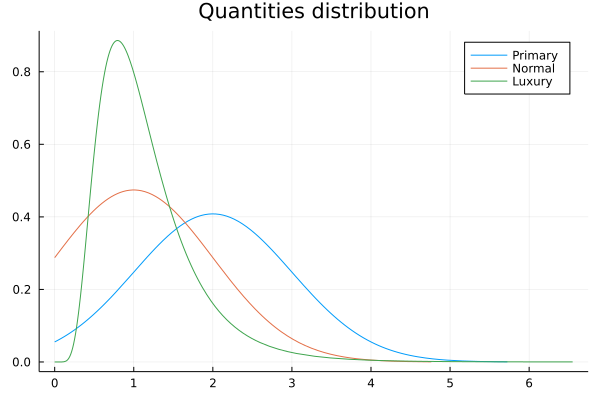

In [19]:
#Economy size
ng=3        #number of sector
na=1000     #number of people
p=[4.0, 5.0, 10.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,0.5)
D_L = truncated(D_L, 0.0, Inf)


qdist=plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

savefig(qdist, "Figures/q_dist.png")
qdist

Equilibrium reached after 85 iterations at prices [1.6969231834495193, 5.849061125844726, 10.231767410110148](W, D, Excess, p) = ([2057.607378544399, 1271.0953477561566, 1142.1214362207882], [2057.6080502628106, 1271.1046640315674, 1142.1160592093777], [0.0006717184114677366, 0.009316275410810704, -0.005377011410473642], [1.6969231834495193, 5.849061125844726, 10.231767410110148])


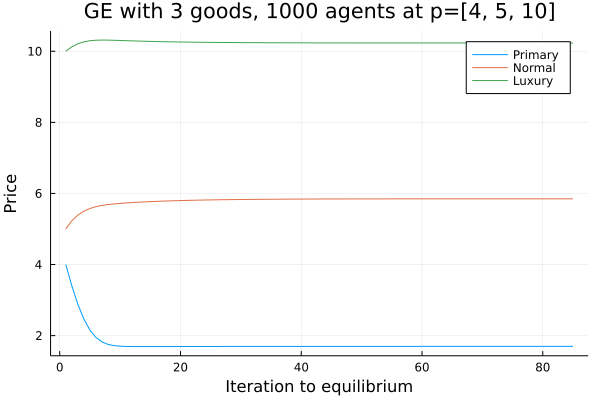

In [22]:
#Initial price level given
p=[4.0, 5.0, 10.0]

#leading to a Expenditure vector evaluated by a distribution of good
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)        #Use to clear market such as Excess <1E-4
pricepath=[]            #track price path

#iterations
tol=1e-2
iter=0
maxiter=400
step=0.001

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        pricepath=push!(pricepath, [p[1] p[2] p[3]])
        for i=1:ng
            p[i]=p[i]+step*Excess[i]
            W[i]=sum(G[j,i] for j=1:na)
            D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
        end
        Excess=D-W
    end
end

print("Equilibrium reached after $iter iterations at prices $p")
@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

p2=plot([p_p p_n p_l], title="GE with $ng goods, $na agents at p=[4, 5, 10]", label=["Primary" "Normal" "Luxury"], xlabel="Iteration to equilibrium", ylabel="Price")
savefig(p2, "Figures/endowge_before.png") # save the most recent fig as filename_string (such as "output.png")
p2


Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [23]:
initial_p=p
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

1000×3 Matrix{Float64}:
 0.415872  0.191986   0.463508
 1.14327   0.18999    0.380936
 1.38091   0.0816422  0.395721
 0.99617   0.216878   0.405191
 1.43438   0.369266   0.305178
 1.30344   0.17604    0.477312
 1.2374    0.113817   0.527684
 0.383249  0.658434   0.411303
 2.43157   0.0314347  0.345763
 1.75707   0.0628171  0.497187
 ⋮                    
 1.66388   0.687375   3.61482
 2.65468   1.19178    3.12213
 1.6417    0.648156   3.6518
 0.339388  1.93212    3.51987
 1.8892    1.38262    3.56316
 1.36642   1.86823    3.61378
 0.813209  1.22742    4.48267
 0.465617  1.71258    4.43068
 2.30932   2.37198    4.4095

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

Equilibrium reached after 74 iterations at prices [2.6522726178218843, 5.807892874313772, 10.065572688743075](W, D, Excess) = ([1646.0859028355194, 1271.0953477561566, 1142.1214362207897], [1646.0871930928165, 1271.1046993396656, 1142.1157562217861], [0.0012902572971142945, 0.00935158350898746, -0.005679999003632474])


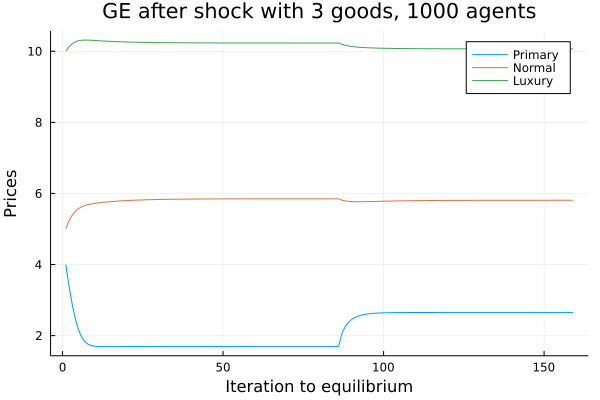

In [24]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
for i=1:ng
    W[i]=sum(n_G[j,i] for j=1:na)
    D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)
end

Excess=D-W

iter_shock=0

for j =1:ng
    while iter_shock<=maxiter && abs(Excess[j])>tol
        iter_shock = iter_shock + 1
        shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.001*Excess[i]
            W[i]=sum(n_G[j,i] for j=1:na)
            D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
        end
    Excess=D-W
    end
end

after_shock_p=p
pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

print("Equilibrium reached after $iter_shock iterations at prices $p")
@show W,D, Excess
pge=plot([p_p p_n p_l], title="GE after shock with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"], xlabel="Iteration to equilibrium", ylabel="Prices")
savefig(pge, "Figures/ge_prices.png") # save the most recent fig as filename_string (such as "output.png")

pge

# Look how it redistributes with fully sticky prices

In [25]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

1000×9 Matrix{Any}:
   1   1.55302  0.51984   0.191986   …  0.725867  0.399672  0.310613
   2   1.8576   1.42909   0.18999       0.789675  0.438716  0.344795
   3   1.86759  1.72614   0.0816422     0.791671  0.439943  0.345875
   4   1.90095  1.24521   0.216878      0.798296  0.444018  0.349465
   5   2.28931  1.79298   0.369266      0.871321  0.48916   0.389494
   6   2.4717   1.62931   0.17604    …  0.903363  0.509096  0.407314
   7   2.47767  1.54676   0.113817      0.904391  0.509737  0.407889
   8   2.57467  0.479061  0.658434      0.920906  0.520043  0.417136
   9   2.57834  3.03946   0.0314347     0.921524  0.520429  0.417482
  10   2.74236  2.19634   0.0628171     0.948703  0.537433  0.432788
   ⋮                                 ⋱                      
  92  48.923    2.07986   0.687375      3.71796   2.43259   2.34548
  93  48.9446   3.31836   1.19178       3.71874   2.43315   2.34608
  94  49.1257   2.05213   0.648156      3.72529   2.43789   2.35119
  95  56.0886   0.424236 

In [41]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

1000×9 Matrix{Any}:
   1   1.47873  0.415872  0.191986   …  0.709326  0.389609  0.301866
   2   1.63983  1.14327   0.18999       0.744675  0.411145  0.320618
   3   1.60543  1.38091   0.0816422     0.737287  0.406635  0.316681
   4   1.70845  0.99617   0.216878      0.759177  0.420012  0.328373
   5   1.99005  1.43438   0.369266      0.815694  0.454735  0.358926
   6   2.18904  1.30344   0.17604    …  0.853133  0.477879  0.379447
   7   2.20866  1.2374    0.113817      0.856726  0.480105  0.381428
   8   2.48837  0.383249  0.658434      0.906229  0.510883  0.408916
   9   2.05307  2.43157   0.0314347     0.827757  0.46218   0.365514
  10   2.34605  1.75707   0.0628171     0.881428  0.495441  0.395098
   ⋮                                 ⋱                      
  92  47.5301   1.66388   0.687375      3.66713   2.39587   2.30591
  93  46.7303   2.65468   1.19178       3.6376    2.37456   2.28297
  94  47.7487   1.6417    0.648156      3.67516   2.40167   2.31215
  95  55.7854   0.339388 

In [42]:
loss=(initial-after_shock)./initial

1000×9 Matrix{Float64}:
 0.0  0.0478339   0.2  0.0  0.0  …  0.0227868   0.0251788   0.0281606
 0.0  0.117235    0.2  0.0  0.0     0.0569852   0.0628464   0.0701217
 0.0  0.140373    0.2  0.0  0.0     0.0686949   0.0757117   0.0844083
 0.0  0.101265    0.2  0.0  0.0     0.0490021   0.0540653   0.0603564
 0.0  0.130722    0.2  0.0  0.0     0.0638415   0.070376    0.07848
 0.0  0.114359    0.2  0.0  0.0  …  0.0556024   0.0613196   0.0684174
 0.0  0.108575    0.2  0.0  0.0     0.0527035   0.0581317   0.0648732
 0.0  0.0335198   0.2  0.0  0.0     0.0159379   0.017614    0.0197051
 0.0  0.203724    0.2  0.0  0.0     0.101752    0.111925    0.12448
 0.0  0.144514    0.2  0.0  0.0     0.0709125   0.0781351   0.0870845
 ⋮                               ⋱                          
 0.0  0.0284701   0.2  0.0  0.0     0.0136706   0.015094    0.0168703
 0.0  0.0452399   0.2  0.0  0.0     0.0218206   0.0240823   0.026902
 0.0  0.0280284   0.2  0.0  0.0     0.0134571   0.0148584   0.0166073
 0.0  0.00

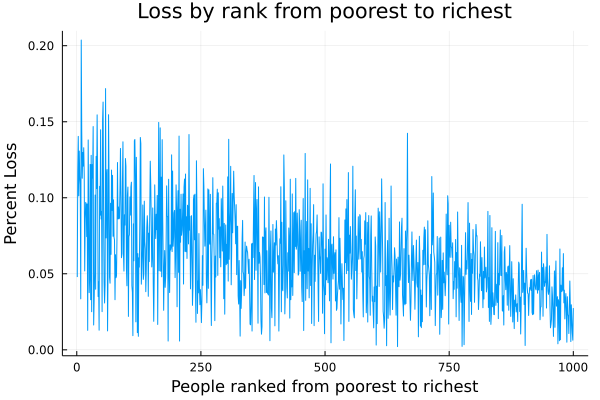

In [43]:
Utility_loss=loss[:,2]
p1=plot(Utility_loss, title="Loss by rank from poorest to richest", xlabel="People ranked from poorest to richest",ylabel="Percent Loss", legend=false)
savefig(p1, "Figures/Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

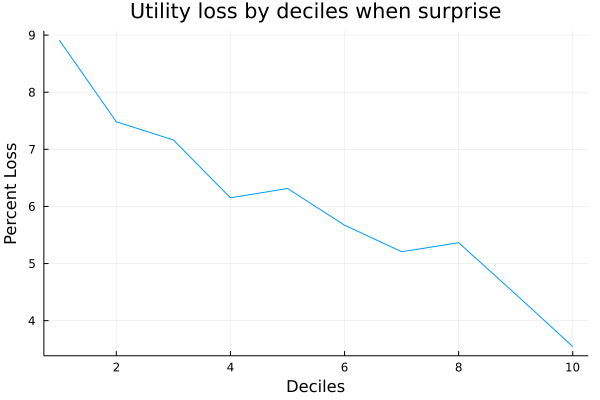

In [44]:
na_n=Int(na/10)
decile=10
dec=reshape(Utility_loss,(na_n,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p2=plot(dec*100, title="Utility loss by deciles when surprise", xlabel="Deciles",ylabel="Percent Loss", legend=false)
savefig(p2, "Figures/Utility_loss_deciles.png") # save the most recent fig as filename_string (such as "output.png")
p2

# Of course if people are not surprised and adjust accordingly right after the shock then it will benefit the most people who have a lot of primary goods

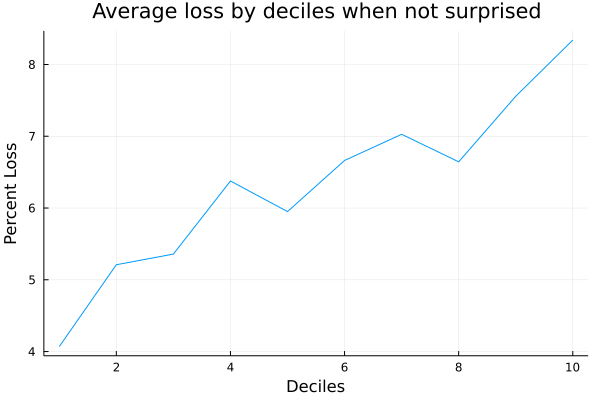

In [45]:
#After the shock without surprise, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(after_shock_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],after_shock_p)[1]
    C2=NHUtility(n_G[a,:],after_shock_p)[2]
    C3=NHUtility(n_G[a,:],after_shock_p)[3]
    Utility=NHUtility(n_G[a,:],after_shock_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

loss=(initial-after_shock)./initial

Utility_loss=loss[:,2]

plot(Utility_loss, title="Loss by rank from poorest to richest", xlabel="People ranked from poorest to richest",ylabel="Percent Loss", legend=false)

na_n=Int(na/10)
decile=10
dec=reshape(Utility_loss,(na_n,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p4=plot(dec*100, title="Average loss by deciles when not surprised", xlabel="Deciles",ylabel="Percent Loss", legend=false)
savefig(p4, "Figures/Utility_loss_decilesnotsurprise.png") # save the most recent fig as filename_string (such as "output.png")
p4
